#  Proyecto: predicción de precios de casas

**Equipo: XX;  
Integrantes: A,B,C;  
Claves únicas: CU-A, CU-B, CU-C.**

Inicio 22/02/2021, Entrega 03/03/2021 a las 2:30pm por correo electrónico identificandolo con `[DL-2021] Equipo XX`.

En este mini proyecto vamos a construir un modelo de predicción de precios de ventas de casas. Los datos son de 
una competencia en [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). El código incluido se encarga de descargar los datos, construir un modelo base y dejar los resultados en el formato de entrega. 
Lo que tendrán que hacer es

1. Desarrollar un mejor modelo predictivo. Encontrarás algunas pistas al final de este archivo. 
1. Hacer la entrega de tus resultados en Kaggle y obtener una captura de pantalla del _score_ de tus respuestas. 

<!--  Por favor incorpora impresion de pantalla de su puntaje -->
![](score.png)

Algunos puntos a considerar:

1. Comiencen lo mas pronto posible. El proceso de selección de hiper-parámetros es tardado y Kaggle sólo acepta un número limitado de entregas al día.
1. Trabajen en equipo. 

La calificación dependerá del lugar que ocupen dentro del _Leaderboard_ en relación con los demás equipos de la clase.

## Importando librerías y módulos

#### Standard library imports

In [10]:
import os
import requests
import zipfile
import tarfile
import hashlib
import sys
import json

#### Third party imports

In [11]:
%matplotlib inline
# %config Completer.use_jedi = False

from d2l import tensorflow as d2l
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer

#### Local application imports

In [12]:
sys.path.append("../../")

In [13]:
%load_ext autoreload
%autoreload 2

from utils.rob.dlp_ml import(
    loss,
    k,
    num_epochs,
    lr,
    weight_decay,
    batch_size,
    
    num_pipeline,
    cat_pipeline,
    
    get_net,
    log_rmse,
    train,
    get_k_fold_data,
    k_fold,
    train_and_pred
)

from utils.rob.dlp_params import (
    features_dict
)

from utils.rob.dlp_funcs import (
    clean_data,
    transform_target_var,
    features_to_pipes,
    features_dictrionary
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
## Name of feature that will be predicted
for feat in features_dict:
    if features_dict[feat]["ml_label"] == True:
        predict_feature = feat

predict_feature

'SalePrice'

---

## Descargando y leyendo los datos

In [15]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [16]:
def download(name, cache_dir=os.path.join('.', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


Lo siguiente se encargará de definir la ruta de dónde extraer los datos. 

In [17]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [18]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [19]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


---

## Tratamiento de los datos

### Limpieza inicial

#### Datos de entrenamiento

In [20]:
## Cleaning data based on definitions dictionary.
housingc = clean_data(train_data)

## Adding training labels to cleaned data.
housingc = housingc.join(train_data[predict_feature])

## Transforming the target variable
housingc = transform_target_var(housingc)

## Training labels
housingc_labs = housingc[predict_feature]

## Training data
housingc.drop(predict_feature, axis=1, inplace=True)

#### Datos de prueba

In [21]:
## Cleaning data based on definitions dictionary.
housingc_test = clean_data(test_data)

### Procesamiento usando pipelines

In [22]:
housingc_num, housingc_cat = features_to_pipes(features_dict)


Features included in the model (76) --> ['MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQ

In [23]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, housingc_num),
    ("cat", cat_pipeline, housingc_cat),
])

#### Datos de entrenamiento

In [24]:
housingc_prp = full_pipeline.fit_transform(housingc)

train_features = tf.constant(housingc_prp, dtype=tf.float32)

train_labels = tf.constant(housingc_labs, dtype=tf.float32)

#### Datos de prueba

In [25]:
housingc_prp = full_pipeline.fit_transform(housingc_test)

test_features = tf.constant(housingc_prp, dtype=tf.float32)

## Entrenamiento

fold 1, train log rmse 0.391820, valid log rmse 0.392167
fold 2, train log rmse 1.670248, valid log rmse 1.686102
fold 3, train log rmse 1.297604, valid log rmse 1.271740
fold 4, train log rmse 0.882971, valid log rmse 0.831622
fold 5, train log rmse 0.637726, valid log rmse 0.687058
5-fold validation: avg train log rmse: 0.976074, avg valid log rmse: 0.973738


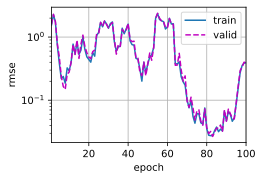

In [26]:
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

---

## Predicción

train log rmse 0.193763


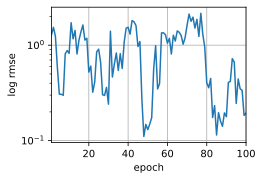

In [27]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

---

## Notas

#### Estudio de los features en gral

#### Playing with features dictionary

---